<a href="https://colab.research.google.com/github/pragneshanekal/NBA-Points-Predictor/blob/main/NBA_Points_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBA Points Predictor

---

This notebook demonstrates the usage of picking the right model to not only make the most accurate predictions but also to obtain an interpretable model that can describe the reason for its predictions.

## Dataset

---



Biometric, biographic and basic box score stats from the 1996 to 2022 season.

The data set contains over two decades of data on each player who has been part of an NBA teams' roster. It captures demographic variables such as age, height, weight and place of birth, biographical details like the team played for, draft year and round. In addition, it has basic box score statistics such as games played, average number of points, rebounds, assists, etc.

## Objective

---



1. Predict a player's scoring average from his seasonal statistics in other key areas.
  - **Question**: Can an NBA player's scoring average be precisely predicted from his other statistical averages?
2. Explore the connections between various performance metrics and a player's scoring average.
  - **Question**: Which non-scoring statistics strongly predict an NBA player's scoring average?

### Install, Import & Initialize Librarires

In [1]:
%pip install h2o
%pip install shap

In [2]:
#### General ####
import numpy as np
import pandas as pd
from google.colab import drive

#### Plots ####
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

#### Sklearn ####
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.pipeline import Pipeline

#### H2O ####
import h2o
from h2o.automl import H2OAutoML

#### Shap ####
import shap

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpoxi2_etr
  JVM stdout: /tmp/tmpoxi2_etr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpoxi2_etr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_dpmu8n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Load Dataset from Google Drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Read dataset (csv) to Pandas df
nba_df = pd.read_csv("/content/drive/My Drive/all_seasons.csv")
nba_df.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


In [6]:
# Then adjust the path to where the file is located in your Google Drive
nba_data = h2o.import_file("/content/drive/My Drive/all_seasons.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
# Make a deep copy of the original dataframe
nba_df_copy = nba_df.copy(deep=True)

### Clean Dataframe

1. Check for **null** values.
2. Drop **index** column from dataset.

#### Pandas Dataframe

In [8]:
# Check if there are any columns with null values
nba_df.isnull().any()

Unnamed: 0           False
player_name          False
team_abbreviation    False
age                  False
player_height        False
player_weight        False
college              False
country              False
draft_year           False
draft_round          False
draft_number         False
gp                   False
pts                  False
reb                  False
ast                  False
net_rating           False
oreb_pct             False
dreb_pct             False
usg_pct              False
ts_pct               False
ast_pct              False
season               False
dtype: bool

In [9]:
# Drop the first column 'Unnamed: 0'
nba_df.drop(columns='Unnamed: 0', inplace=True)

# Verify all columns that exist after dropping Unnamed: 0
nba_df.columns

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object')

#### H2O Dataframe

In [10]:
nba_data.types

{'C1': 'int',
 'player_name': 'enum',
 'team_abbreviation': 'enum',
 'age': 'int',
 'player_height': 'real',
 'player_weight': 'real',
 'college': 'enum',
 'country': 'enum',
 'draft_year': 'int',
 'draft_round': 'int',
 'draft_number': 'int',
 'gp': 'int',
 'pts': 'real',
 'reb': 'real',
 'ast': 'real',
 'net_rating': 'real',
 'oreb_pct': 'real',
 'dreb_pct': 'real',
 'usg_pct': 'real',
 'ts_pct': 'real',
 'ast_pct': 'real',
 'season': 'enum'}

In [11]:
nba_data = nba_data.drop('C1')

# Convert categorical columns to factors
categorical_columns = ['draft_year',
                       'draft_round', 'draft_number']
for col in categorical_columns:
    nba_data[col] = nba_data[col].asfactor()

# Verify the conversion
nba_data.types

{'player_name': 'enum',
 'team_abbreviation': 'enum',
 'age': 'int',
 'player_height': 'real',
 'player_weight': 'real',
 'college': 'enum',
 'country': 'enum',
 'draft_year': 'enum',
 'draft_round': 'enum',
 'draft_number': 'enum',
 'gp': 'int',
 'pts': 'real',
 'reb': 'real',
 'ast': 'real',
 'net_rating': 'real',
 'oreb_pct': 'real',
 'dreb_pct': 'real',
 'usg_pct': 'real',
 'ts_pct': 'real',
 'ast_pct': 'real',
 'season': 'enum'}

### Distribution Analysis

---



The following section analyzes the distributions of the data present in the dataframe. It has been divided into two parts:

- **Categorical Columns**:
  - **Count plots** are plotted to show the counts of observations in each categorical bin.
  - **Violin plots** are plotted to show the distribution shape of 'pts' for each category along with a kernel density estimate through box plots.
- **Numerical Columns**:
  - **Histograms** are plotted to visualize the distribution of a single numerical variable.
  - **Scatter plots** are plotted to visualize the relationship between the numerical variable and the predictor variable, 'pts'.
  - **Correlation heatmap** is plotted to visualize any multicollinearity that exists between columns.

In [12]:
nba_df.dtypes

player_name           object
team_abbreviation     object
age                  float64
player_height        float64
player_weight        float64
college               object
country               object
draft_year            object
draft_round           object
draft_number          object
gp                     int64
pts                  float64
reb                  float64
ast                  float64
net_rating           float64
oreb_pct             float64
dreb_pct             float64
usg_pct              float64
ts_pct               float64
ast_pct              float64
season                object
dtype: object

#### Categorical Columns

**Count Plot**



<Figure size 1000x800 with 0 Axes>

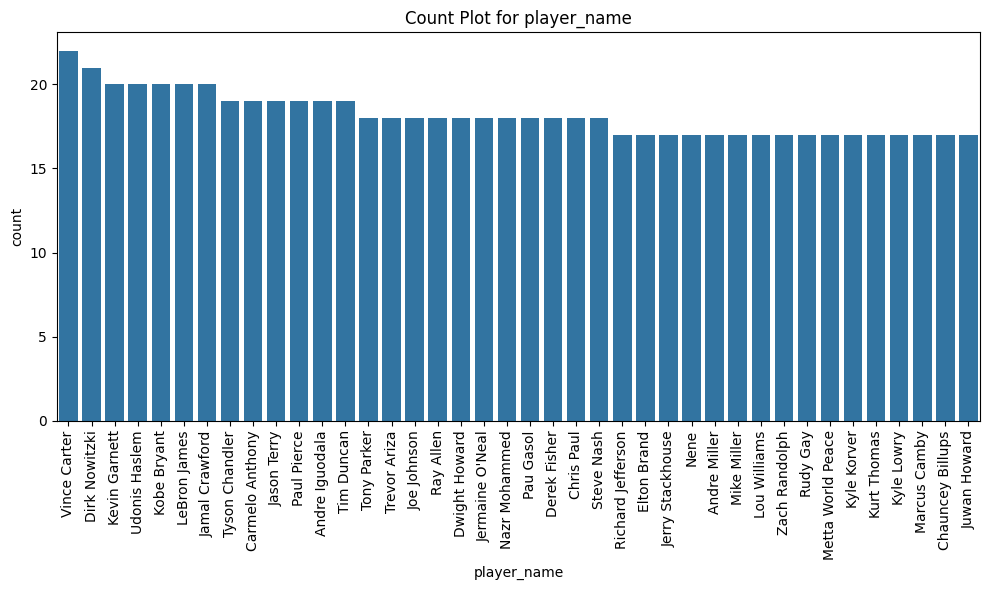

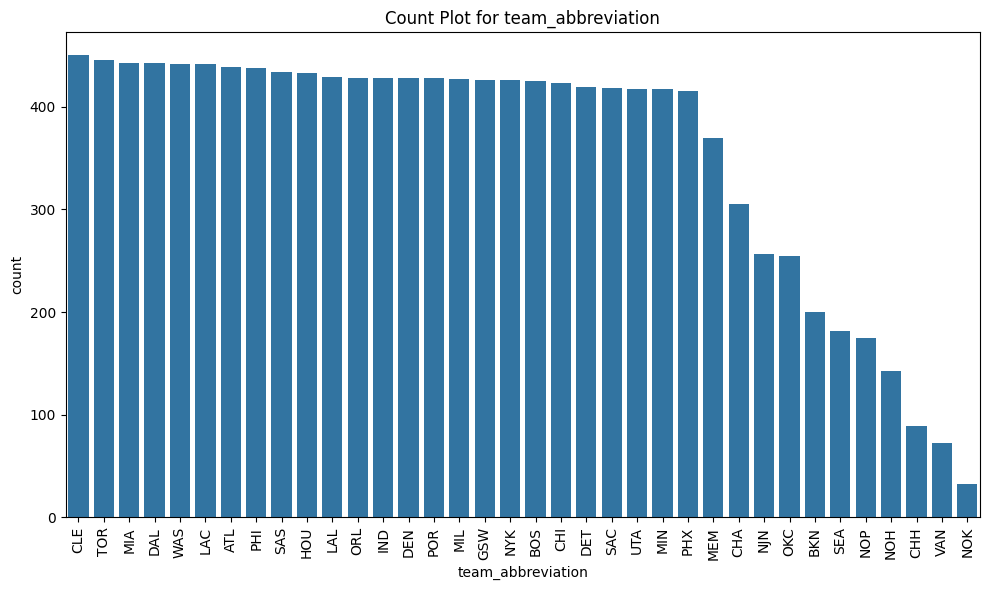

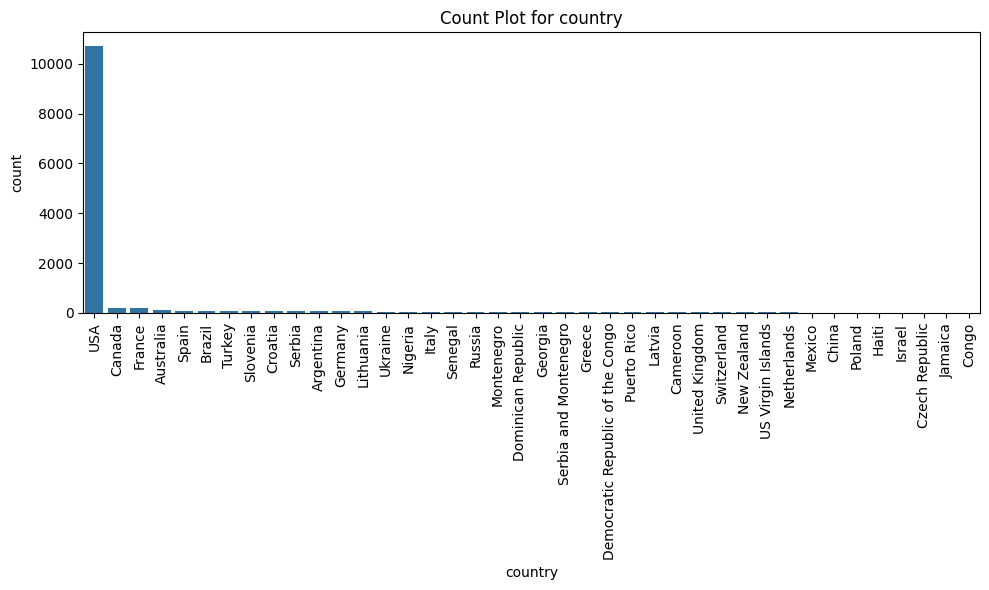

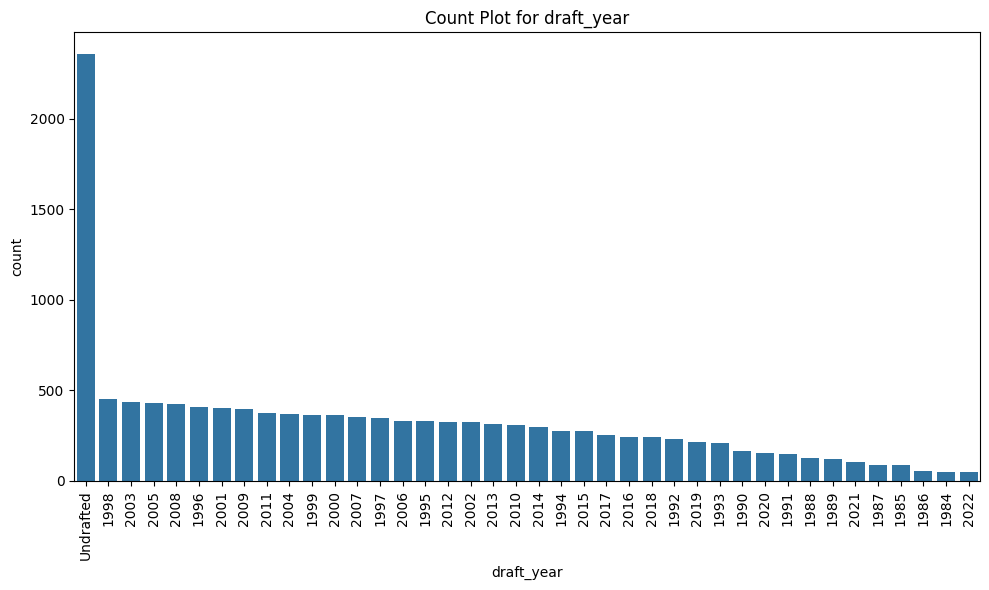

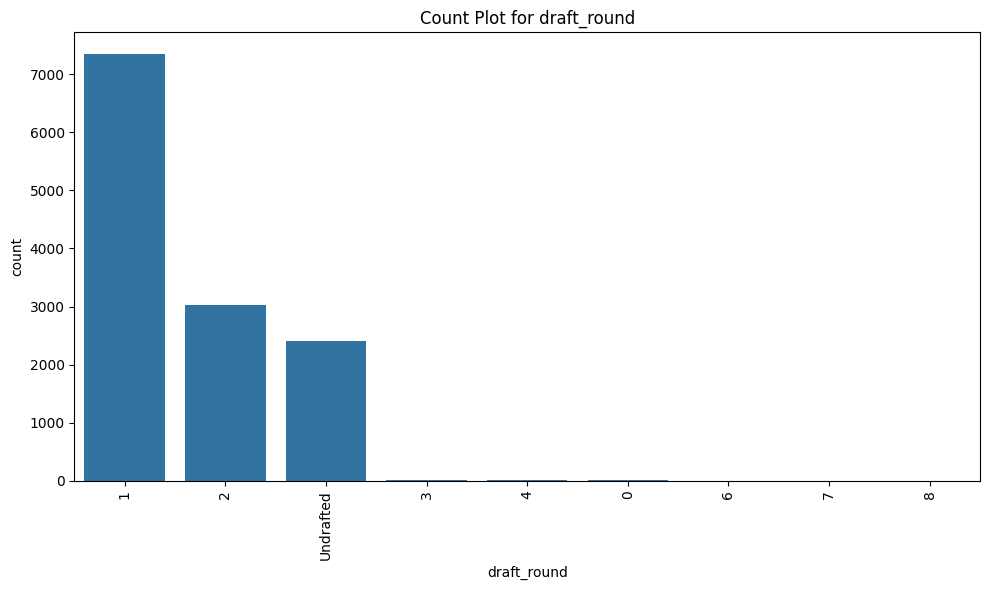

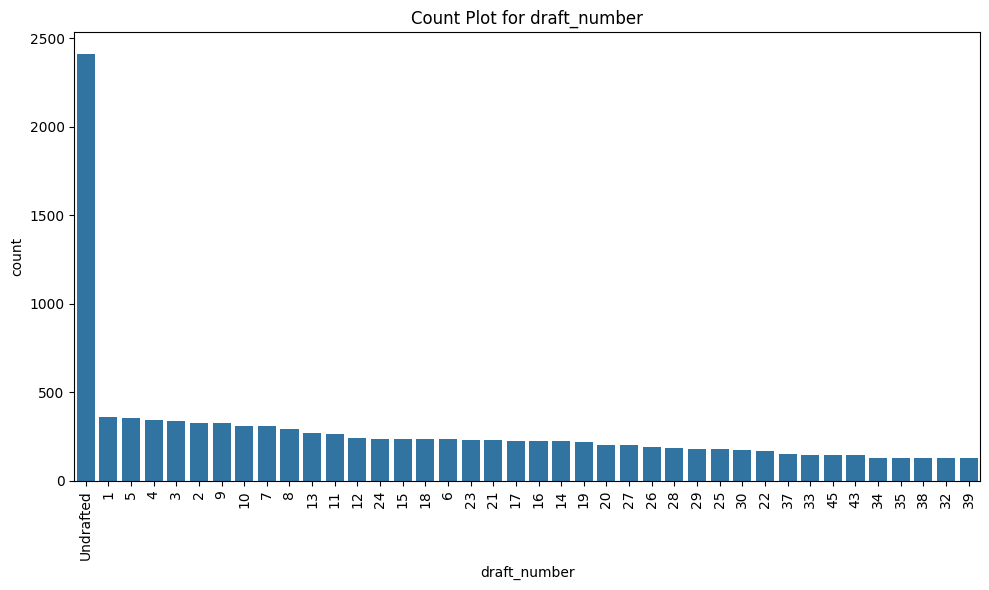

In [13]:
# List of categorical columns (except player_name, college and season)
categorical_columns = ['player_name', 'team_abbreviation', 'country', 'draft_year', 'draft_round', 'draft_number']

# Set the size of the plots
plt.figure(figsize=(10, 8))

# Number of top categories you want to display
top_categories_count = 40

# Loop through each categorical column
for i, column in enumerate(categorical_columns, 1):
    plt.figure(figsize=(10, 6))  # Adjust the size as needed for each plot
    sns.countplot(x=column, data= nba_df, order = nba_df[column].value_counts().index[:top_categories_count])
    plt.title(f'Count Plot for {column}')
    plt.xticks(rotation=90)  # Rotate labels to prevent overlap, adjust as needed
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

1. **Player Name**: Shows the distribution of the top 40 basketball players by name, ensuring readability and interpretability by limiting the number of categories displayed.

2. **Team**: Displays the frequency of players across different basketball teams, indicating a relatively balanced distribution with most teams having a similar number of players represented in this dataset. (*Note*: The decrease towards the end is for teams that no longer exist in the NBA; due to renaming
of a team or otherwise.)

3. **Country**: Shows that the majority of players in the dataset are from the USA.

4. **Draft Year**: Illustrates that the majority of players in the dataset were drafted in earlier years, with a particularly large number of undrafted players.

5. **Draft Round**: Indicates that 1st draft picks are the most common in this dataset, followed by 2nd picks, with a significant number of players being undrafted, and very few from later rounds, reflecting the typical structure of the basketball draft system.

6. **Draft Number**: Indicates a high number of undrafted players in the dataset, with a decreasing frequency of players as the draft number increases, suggesting that early draft picks are more common.

**Violin Plot**

In [14]:
# Method to plot violin plots for different columns
def plot_violiin_plot(df, columns):
  # Define the number of subplots based on the number of categorical columns
  num_plots = len(columns)
  num_rows = int(num_plots / 2) + (num_plots % 2 > 0)  # This ensures we have enough rows in the subplot

  # Set the figure size
  plt.figure(figsize=(15, 5 * num_rows))

  # Loop through each categorical column to create a violin plot for each
  for i, column in enumerate(columns, 1):
      plt.subplot(num_rows, 2, i)  # Adjust subplot index
      sns.violinplot(x=column, y='pts', data=df)
      plt.title(f'Violin Plot of pts vs {column}')
      plt.xticks(rotation=45)  # Rotate x labels for better readability if necessary
      plt.tight_layout()  # Adjust layout to make room for the x-axis labels

  # Show the plot
  plt.show()

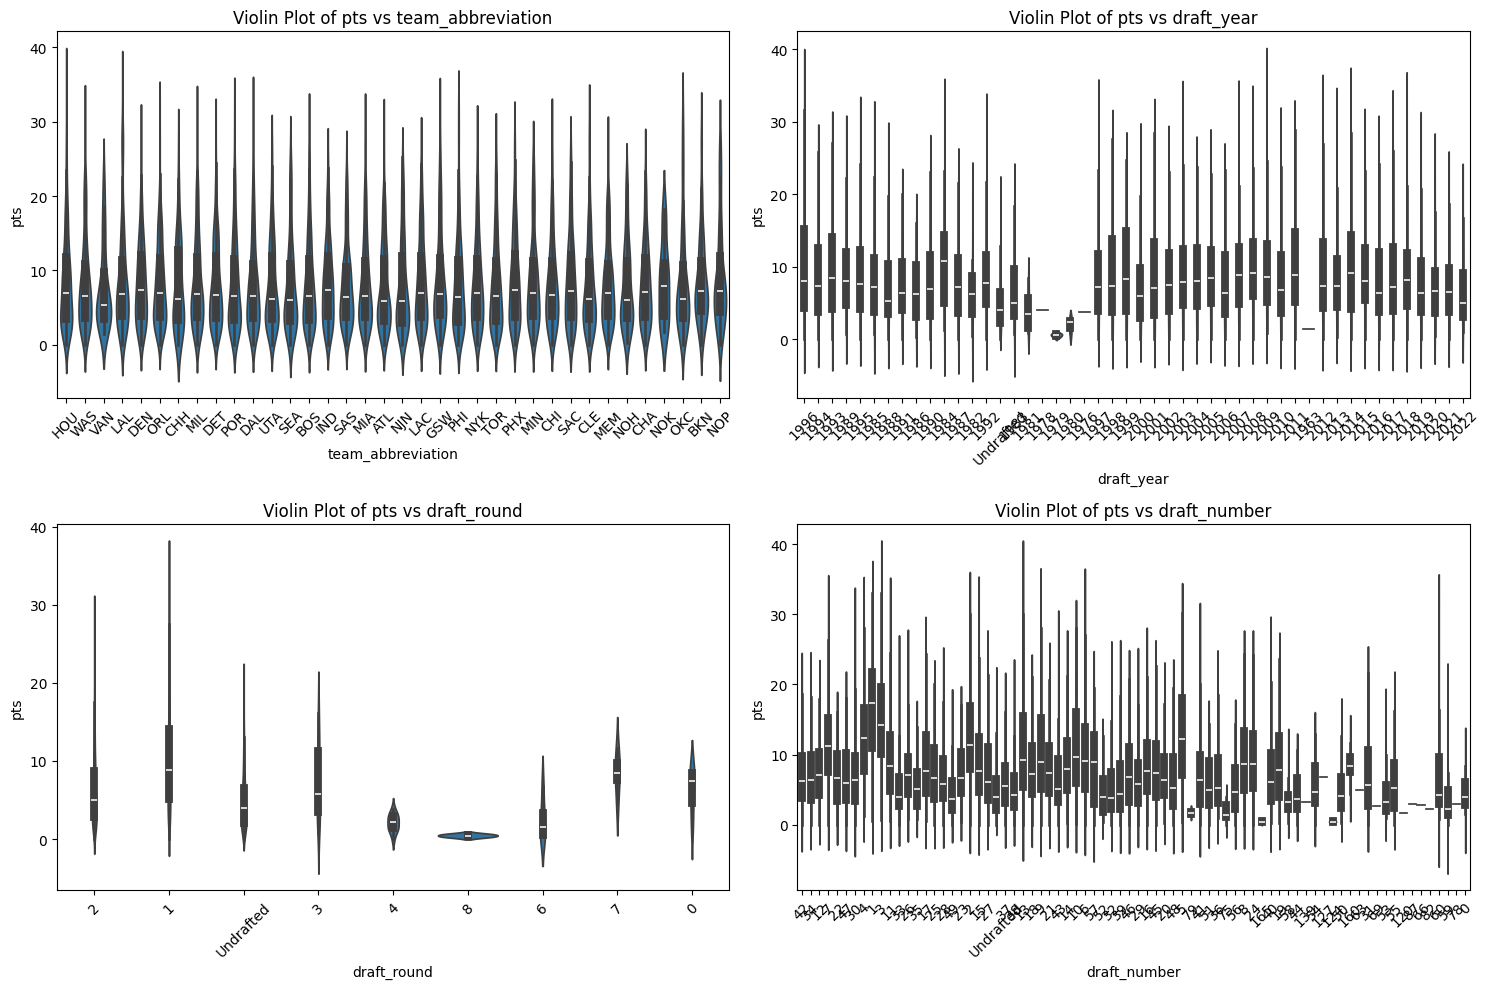

In [15]:
# List of categorical columns (except player_name, college and season)
vo_categorical_columns = ['team_abbreviation', 'draft_year', 'draft_round', 'draft_number']

# Plot violin plot for the categorical columns
plot_violiin_plot(nba_df, vo_categorical_columns)

For Points Scored vs:

1. **Team**: The distribution for most teams shows a similar median and distribution of points across different players.

2. **Draft Year**: Points scored by players do not show a clear trend with respect to their draft year.

3. **Draft Round**: Shows a relatively consistent median across different draft rounds, with undrafted players having a broader range of 'pts' scored, and fewer observations in later rounds.

4. **Draft Number**: Distribution of points scored by players varies across different draft numbers, with a wide range of scoring performance regardless of draft position.

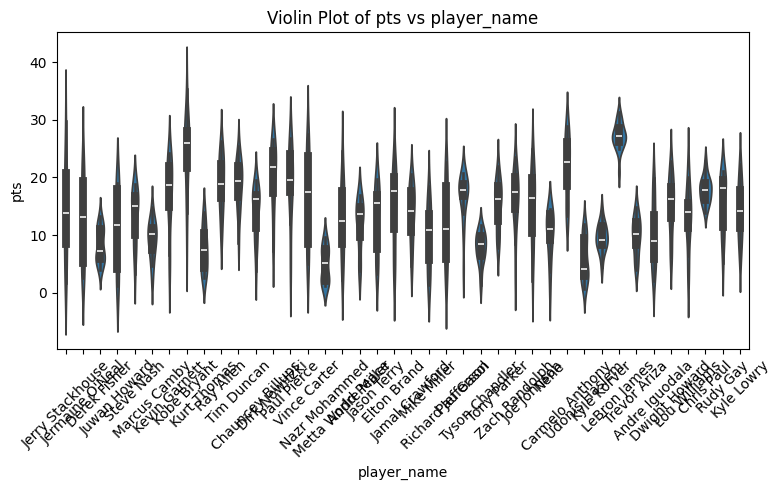

In [16]:
# The specific categorical column you want to analyze
categorical_column = 'player_name'  # Replace with your specific column name

# Determine the top 40 categories in the specified column
top_categories = nba_df[categorical_column].value_counts().index[:40]

# Filter the DataFrame to include only the top 40 categories
filtered_df = nba_df[nba_df[categorical_column].isin(top_categories)]

# Plot violin plot for the top 40 player_name categories
plot_violiin_plot(filtered_df, [categorical_column])

**Player Name**: Points distribution ('pts') for individual players indicates variability in scoring with some players exhibiting a notably higher range and median points scored than others

#### Numerical Columns

**Histogram**

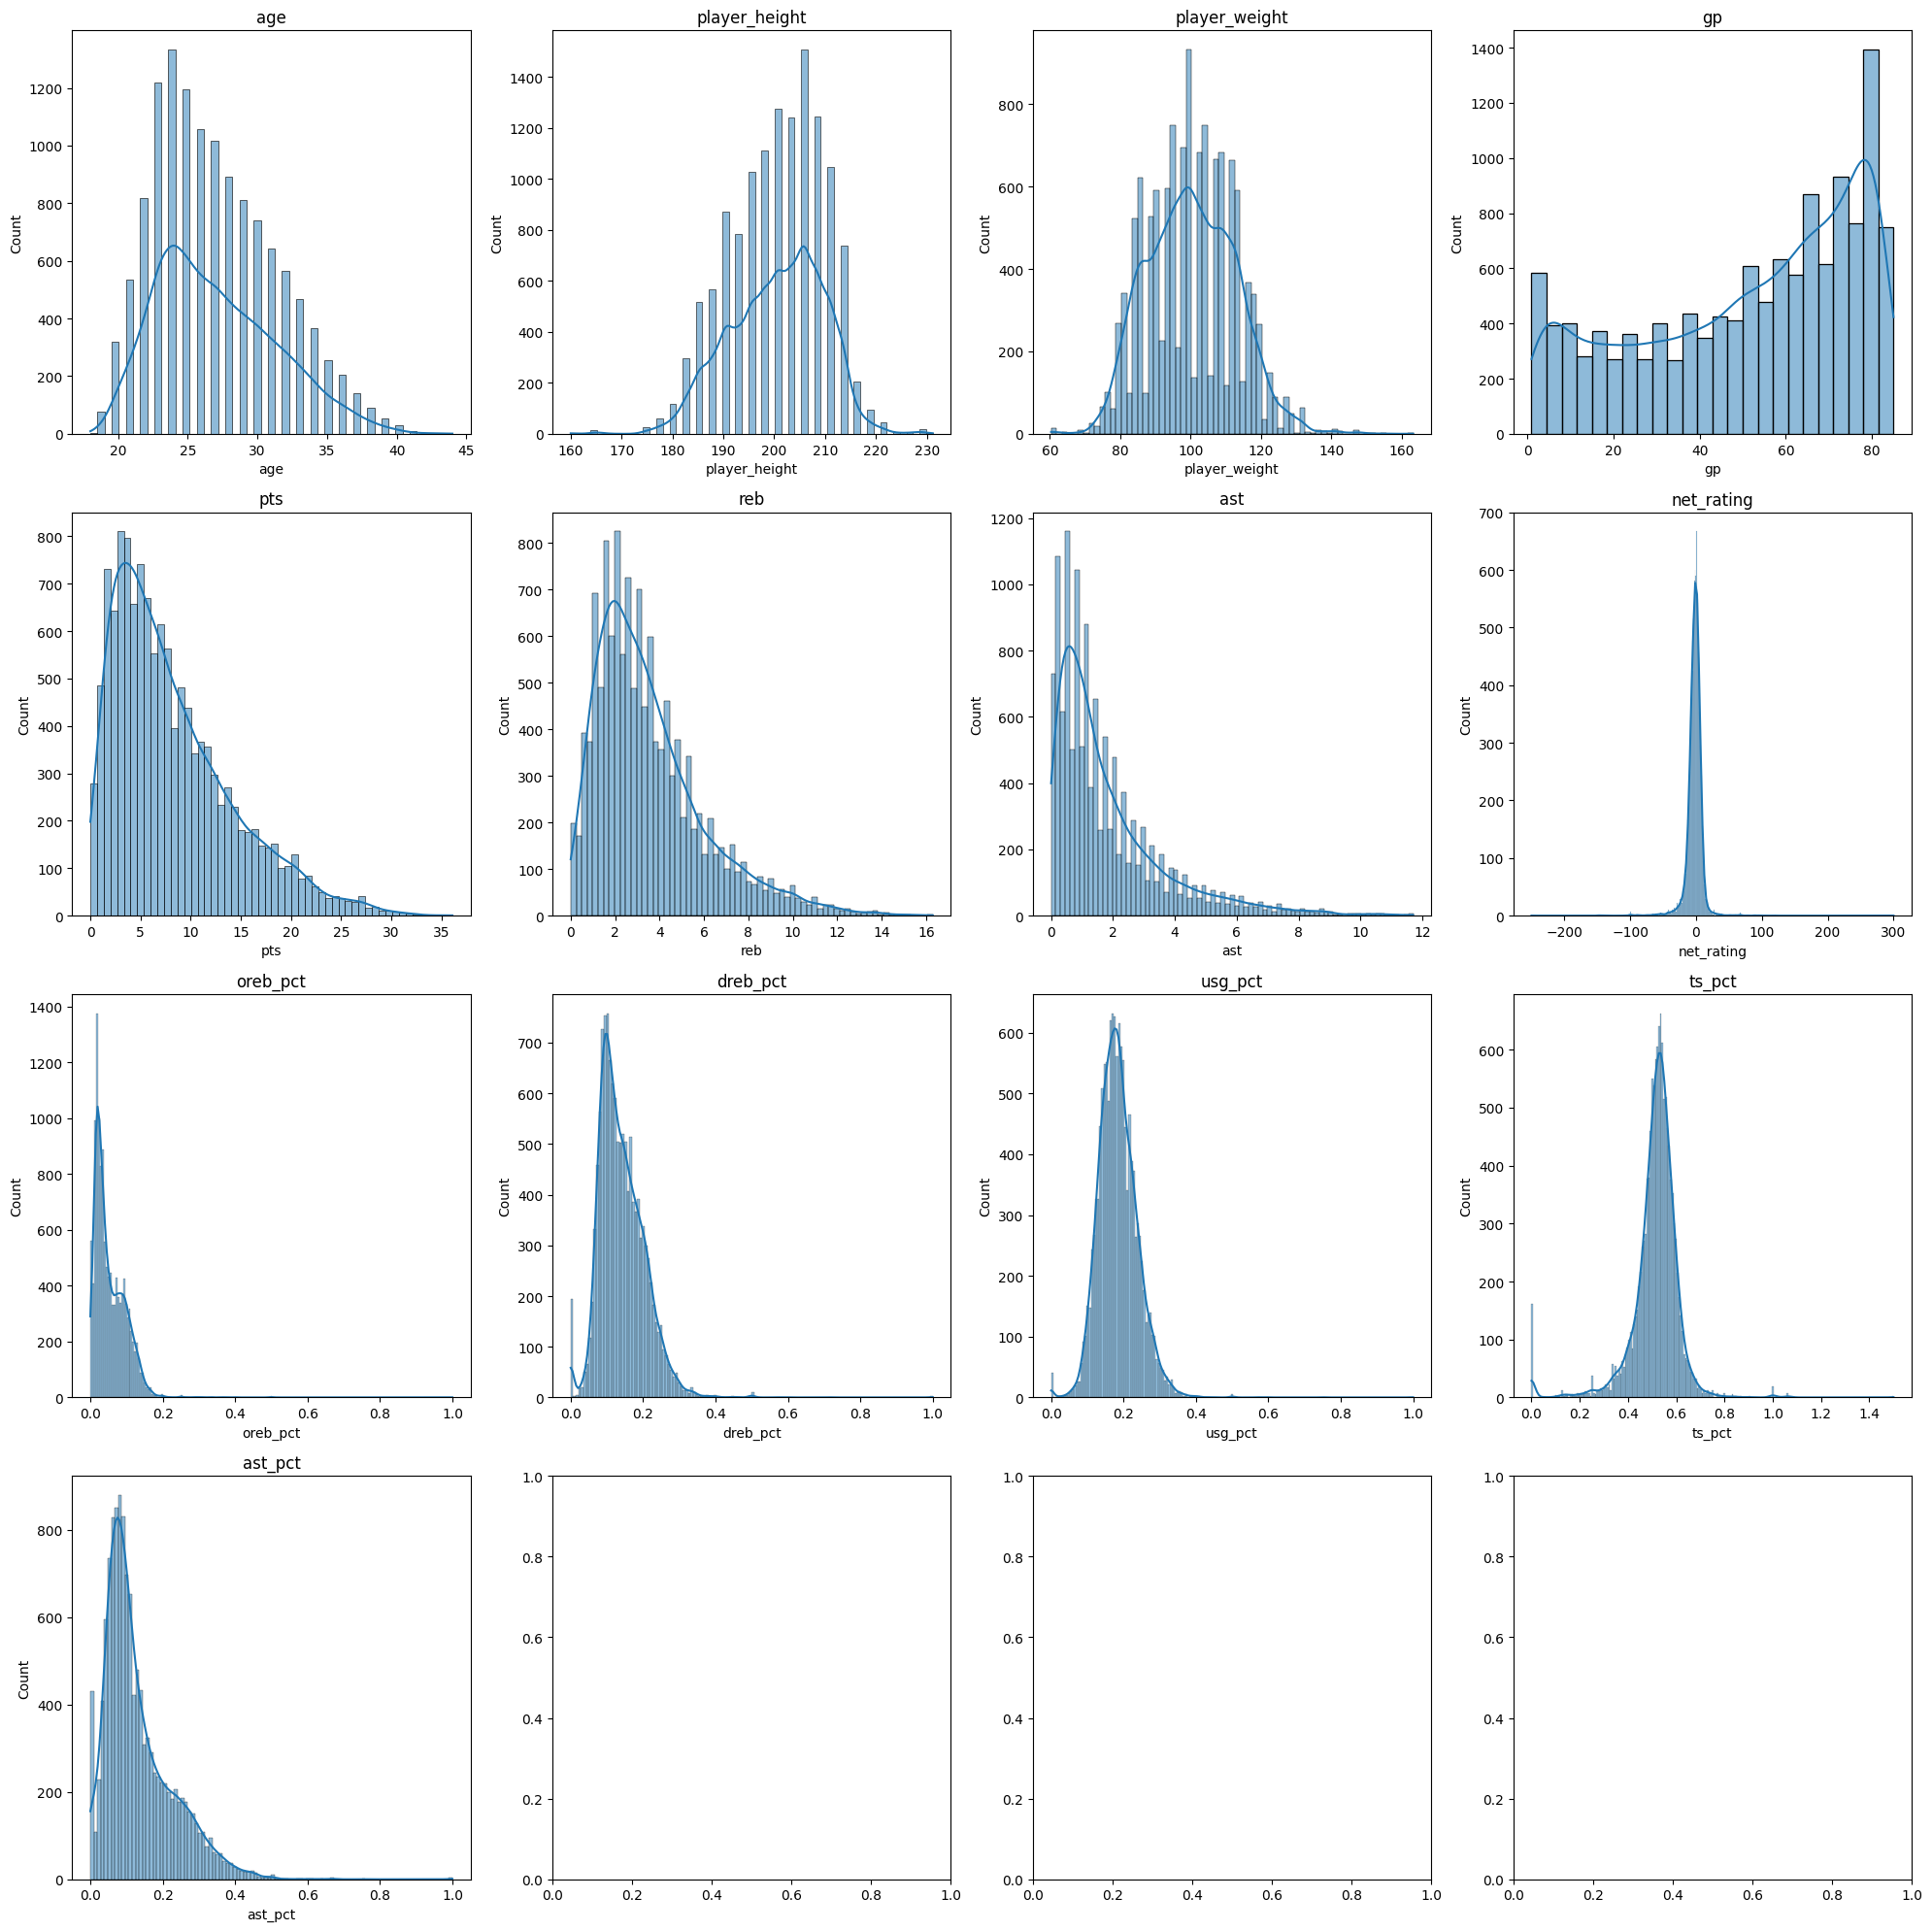

In [17]:
# List of numerical columns
numerical_columns = ['age', 'player_height', 'player_weight', 'gp', 'pts',
                     'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct',
                     'usg_pct', 'ts_pct', 'ast_pct']

# Set up subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numerical_columns):
    sns.histplot(nba_df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# Adjust layout
plt.tight_layout()
plt.show()

1.   **Age**: Age follows a somewhat right skewed distribution, with a peak around the mid-to-late 20s, reflecting the typical age range of professional basketball players.
2.   **Height & Weight**: They follow a roughly normal distribution, with a peak around the average for NBA players (around 200 cm height), tapering off towards both shorter and taller ranges.
3.   **Games Played**: The distribution of games played is right-skewed, with most players participating in a similar number of games (around 75) each season and a smaller number of players missing significant portions of the season due to injuries or other reasons.
4.   **Rebounds, & Assists**: They all follow a right-skewed distribution, with many players scoring fewer points, rebounds and assists per game and a smaller number of high-scoring players contributing to a longer right tail.
5.   **Net Rating**: Net rating follows a roughly normal distribution, centered around zero, with teams having roughly equal numbers of positive and negative net ratings.
6.   **Offensive & Defensive Rebound Strategies**: This variable skewed towards lower values, with most players having lower rebound percentages and fewer players with very high percentages.
7.   **Usage and True Shooting Percentage**: This follows a normal distribution, with most players clustered around the average.
8.   **Assist Percentage**: They follow a slightly right-skewed distribution. The majority of players have lower assist percentages, while there are relatively fewer players with very high assist percentages.

**Scatter Plots**

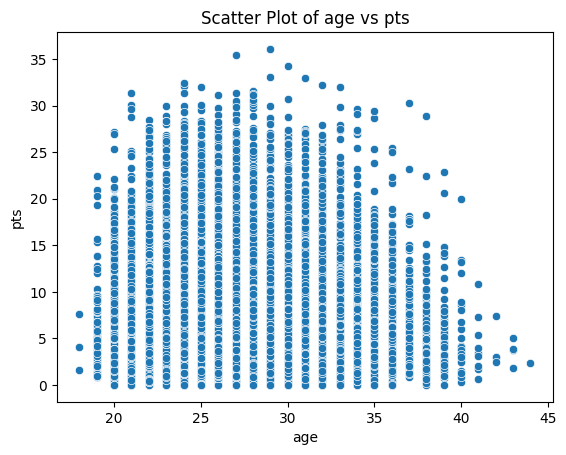

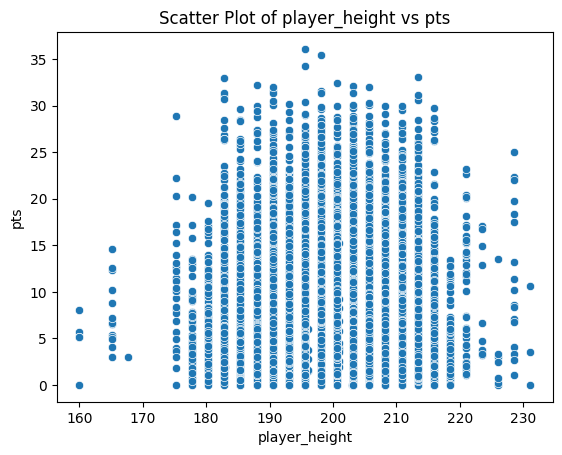

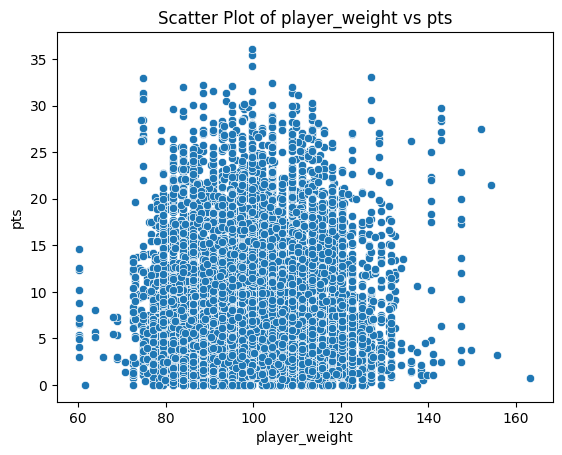

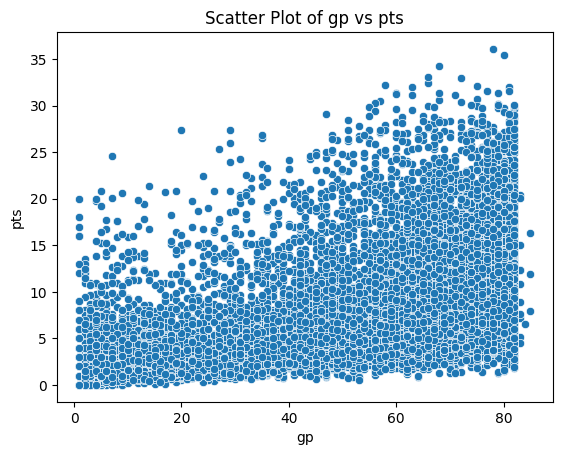

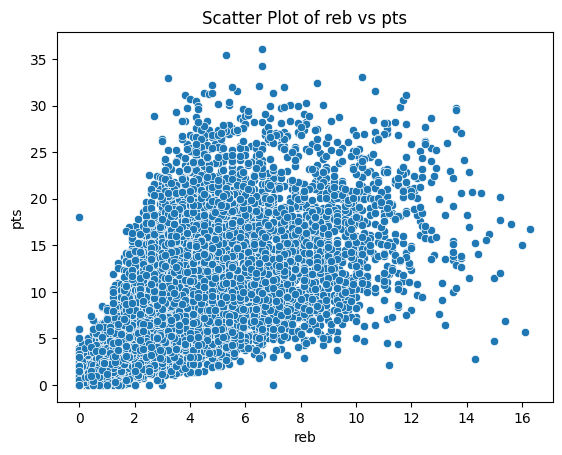

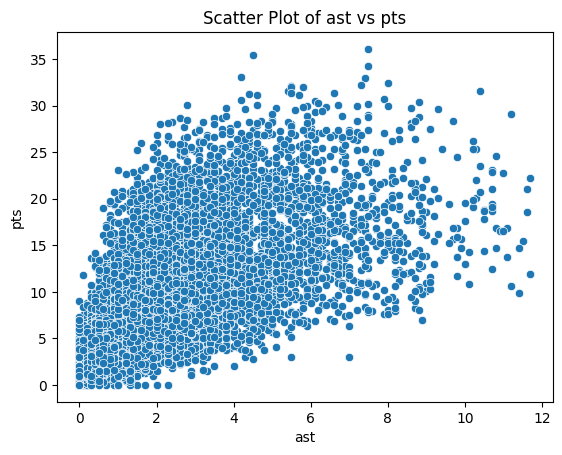

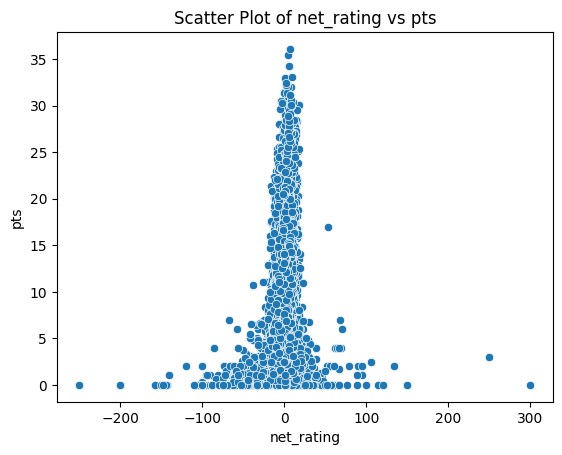

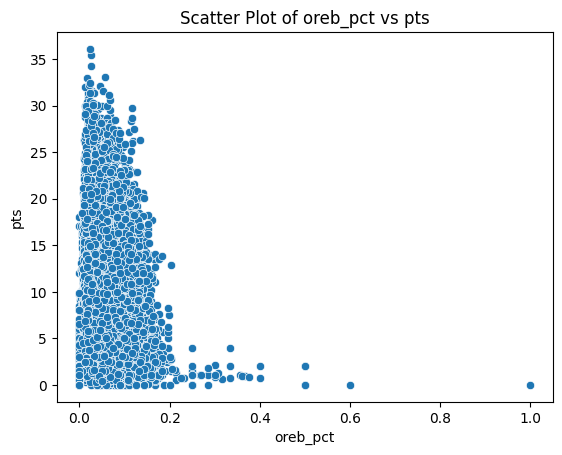

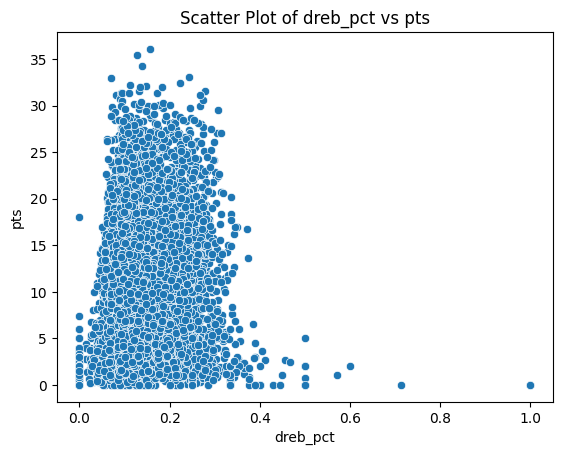

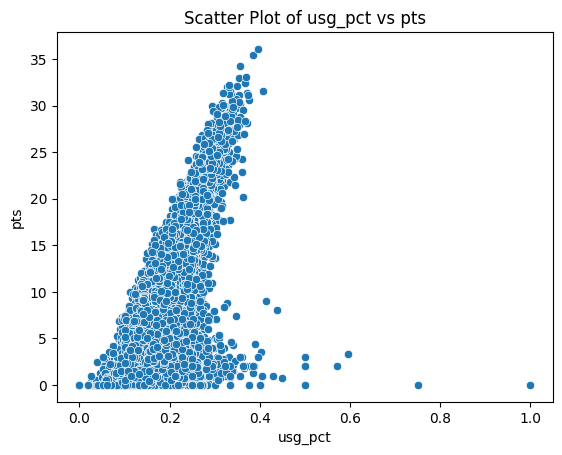

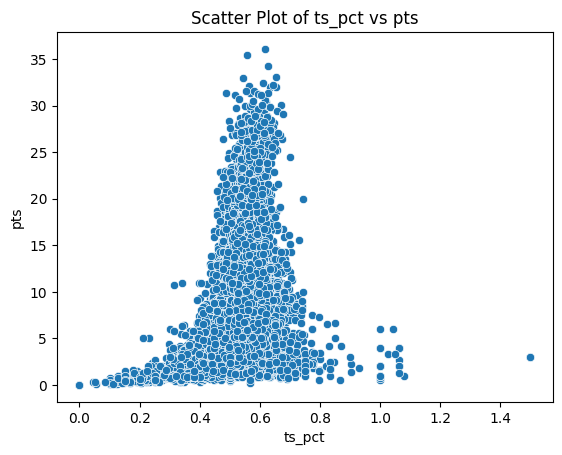

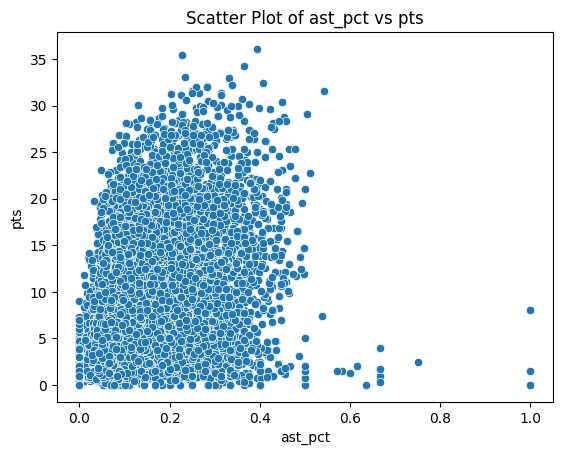

In [18]:
# Make scatter plots for each numerical column vs pts
for column in numerical_columns:
    if column != 'pts':  # Avoid plotting 'pts' against itself
        sns.scatterplot(x=nba_df[column], y=nba_df['pts'])
        plt.title(f'Scatter Plot of {column} vs pts')
        plt.xlabel(column)
        plt.ylabel('pts')
        plt.show()

For points scored:

1. **Age, Player Height & Weight**: Indicates no clear correlation between the column and points scored, with players of various values scoring across a wide range of points.

2. **Games Played, Rebounds, Assists, Usage Percentage**: Positive relationship is observed across these columns, where a higher value within these columns tends to correlate with higher points scored by the players.

3. **Net Rating**: Concentration of data around a net rating of zero, without a clear correlation between net rating and points scored, suggesting that net rating may not be a strong predictor of individual scoring performance.

4. **Off-Reb, Def-Reb and Assist %**: No strong correlation between these columns and points scored, as players across a wide range of values score similarly.

5. **True Shooting %**: Dense concentration of data points with higher true shooting percentages (ts_pct) generally correlating with a moderate increase in points scored, but the relationship does not appear to be strictly linear.

**Correlation Heatmap**

<ipython-input-19-643aded023b4>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(nba_df.corr(), annot=True, cmap="RdYlGn")


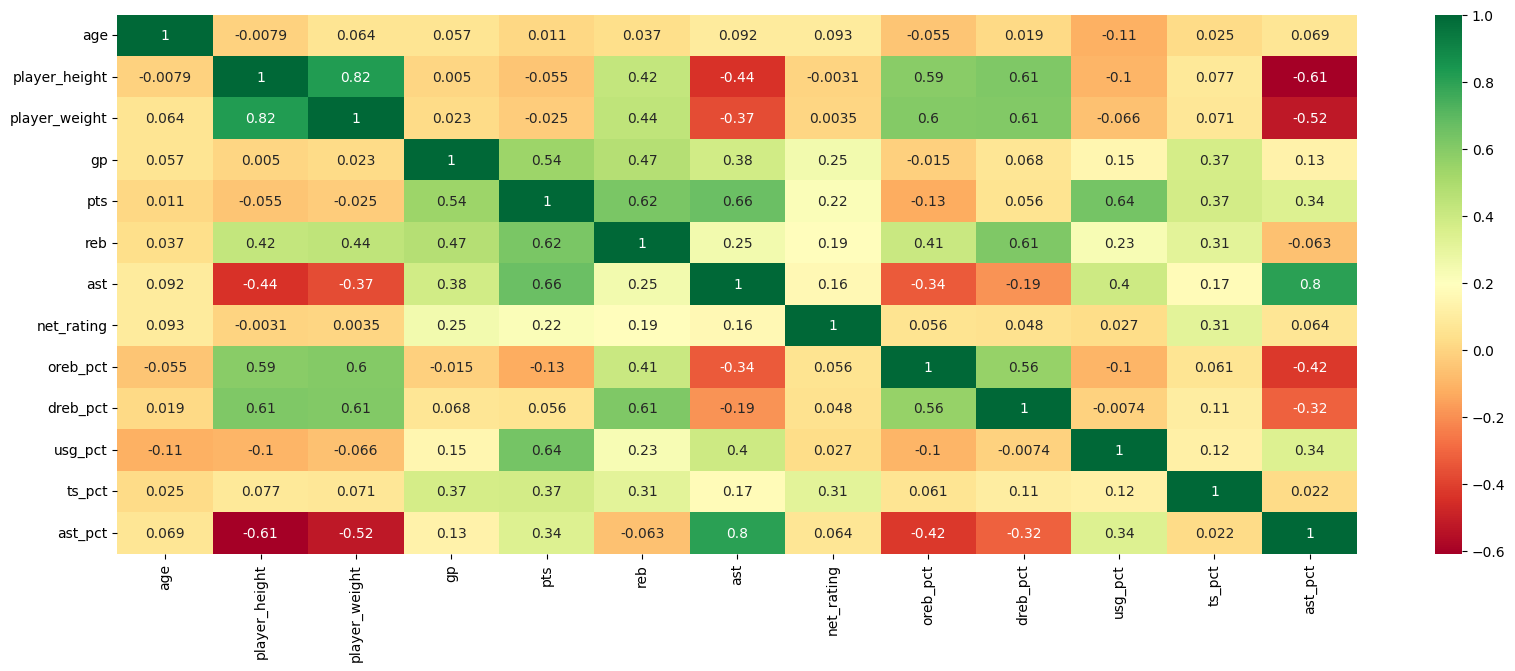

In [19]:
# Plot the heatmap to determine if any columns are highly correlated to each other
plt.figure(figsize=(20, 7))
sns.heatmap(nba_df.corr(), annot=True, cmap="RdYlGn")
plt.show()

### Encoding Categorical Columns

---



- To transform the **'player_name'** categorical variable into a format suitable for machine learning algorithms, a dummy encoding technique has been applied. This technique involved creating binary indicator variables for each unique player name.
- To prevent the issue of multicollinearity, which can occur due to the interdependencies between the created dummy variables, the first indicator variable was omitted.

In [20]:
# Perform dummy encoding of column 'player_name'
nba_df = pd.get_dummies(data=nba_df, prefix='player', columns=['player_name'], drop_first=True)

### Feature Selection

---



The following section performs feature selection through one main technique:

1. Choosing the columns based on the objective of the regression problem.

The study focuses on the player's controllable non-scoring stats that influence their points per game, hence columns **Team, College, Country, Draft Year, Number, Round, Age, Player Height and Weight and Season** were removed for irrelevance to the player's in-season performance.

In [21]:
# Categorical columns that need to be dropped
cat_columns_dropped = ['team_abbreviation', 'college', 'country', 'draft_year', 'draft_number', 'draft_round', 'season']

nba_df.drop(columns=cat_columns_dropped, inplace=True)

In [22]:
# Numerical columns that need to be dropped
num_columns_dropped = ['age', 'player_height', 'player_weight']

nba_df.drop(columns=num_columns_dropped, inplace=True)

### Model Training

---



The model training section utilizes Ridge regression, summarized through these key steps:

**Step 1**: Split the data into **training** and **holdout test** sets for training and validation.

**Step 2**: Perform Ridge regression on the **training data** by standardizing features and identifying the optimal **regularization parameter** (alpha) via cross-validation with **RidgeCV**.

**Step 3**: Use **cross_val_score** to conduct cross-validation on the full training dataset for model evaluation using the chosen alpha value.

**Step 4**: Assess the model on the **holdout test** set for an unbiased performance estimate.

**Step 5**: For deployment or further predictions, retrain the model on the **entire dataset**, applying the optimal alpha.

Additionally, **AutoML training** is performed to compare non linear to linear models using H2O AutoML.

#### Step 1: Splitting Data into Training and Holdout Set

In [23]:
# Split data into training and holdout set
X = nba_df.drop(columns='pts')
y = nba_df['pts']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Step 2: Ridge Regression through 5-fold Cross Validation - Best Alpha Value

In [24]:
# Create a pipeline that standardizes, then runs RidgeCV
ridge_pipeline = Pipeline([
    ('ridge_scaler', StandardScaler()),
    ('ridge_cv', RidgeCV(cv=5))
])

# Fit the model to the training data
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ridge_scaler', StandardScaler()),
                ('ridge_cv', RidgeCV(cv=5))])

In [25]:
# Extract the Ridge object from the pipeline
ridgecv_model = ridge_pipeline.named_steps['ridge_cv']

# Get best alpha value
ridgecv_model.alpha_

10.0

#### Step 3: Use Cross Validation to Evaluate the Model

In [26]:
# Step 3: Evaluate the Model with Cross-Validation
ridge_cv_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=5)

In [27]:
# Print R2 value for each fold from training set
for score in ridge_cv_scores:
  print(score)

0.9124625863336421
0.8989462112191654
0.9120816756343475
0.9013414186268957
0.899532468665649


#### Step 4: Assess Model on Holdout Set

In [28]:
# Fit model on training data using chosen alpha value and test it on holdout set
ridge_final_pipeline = Pipeline([('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=ridgecv_model.alpha_))
])

ridge_final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=10.0))])

In [29]:
# Step 4: Evaluate on Holdout Test Set
ridge_test_score = ridge_final_pipeline.score(X_test, y_test)

# R2 value for test set
print(ridge_test_score)

0.92477881276612


#### Step 5: Train Model on Entire Dataset

In [30]:
ridge_final_pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=10.0))])

#### AutoML Model

In [31]:
# Set predictor and response variable for H2O dataframe
response = "pts"
predictors = list(nba_data.columns)
predictors.remove('pts')

# Initalize AutoML instance with run time of 5 minutes and 5-fold cross validation
aml = H2OAutoML(max_runtime_secs=300, seed=1, nfolds = 5)

# Train the AutoML instance to obtain leaderboard
aml.train(x=predictors, y=response, training_frame=nba_data)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/12
# GBM base models (used / total),1/5
# XGBoost base models (used / total),3/3
# DRF base models (used / total),0/2
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [32]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_1_20240402_230611,0.745103,0.555179,0.51822,nan,0.555179
StackedEnsemble_AllModels_1_AutoML_1_20240402_230611,0.753,0.567009,0.525235,nan,0.567009
StackedEnsemble_BestOfFamily_3_AutoML_1_20240402_230611,0.793892,0.630264,0.557144,nan,0.630264
StackedEnsemble_BestOfFamily_2_AutoML_1_20240402_230611,0.793968,0.630386,0.557164,nan,0.630386
StackedEnsemble_BestOfFamily_1_AutoML_1_20240402_230611,0.794397,0.631067,0.557435,nan,0.631067
GBM_1_AutoML_1_20240402_230611,0.936028,0.876147,0.665125,nan,0.876147
XGBoost_1_AutoML_1_20240402_230611,0.941606,0.886621,0.682504,nan,0.886621
XGBoost_3_AutoML_1_20240402_230611,1.01726,1.03481,0.737264,nan,1.03481
XGBoost_2_AutoML_1_20240402_230611,1.02544,1.05153,0.734097,nan,1.05153
GBM_2_AutoML_1_20240402_230611,1.07462,1.15481,0.764487,0.147712,1.15481



- The AutoML models achieved an impressive **R2 score of 0.98** through 5-fold cross-validation.
- The regularized linear model obtained an **R2 of 0.92**.
- Considering our **goal to interpret the model's results**, the **linear model is preferred** despite its slightly lower R2 score, due to its greater interpretability compared to a complex ensemble model.

### Model Assumption Validation

---



This section focuses on validating the linear model assumptions for a regression problem. The objective is to determine if linear model was the right model to use given the dataset. The following assumptions have been validated for the residuals:

1. **Normality**
2. **Autocorrelation**
3. **Pattern in Residuals**

In [33]:
# Method to validate the linear model assumptions of residuals (Autocorrelation, Normality, Pattern in Residuals)
def assumptionValidation(y_pred, residual):
  # Scatter Plot Residuals
  plt.scatter(y_pred, residual)
  plt.xlabel("Predicted Values")
  plt.ylabel("Residuals")
  plt.title("Residual Plot")
  plt.axhline(y=0, color='r', linestyle='--')
  plt.show()

  # Residuals Autocorrelation Plot
  plot_acf(residual, lags=20)
  plt.xlabel("Lag")
  plt.ylabel("Autocorrelation")
  plt.title("Autocorrelation of Residuals")
  plt.show()

  # Normality of Residuals
  p = sns.histplot(residuals, kde=True)
  p = plt.title('Normality of error terms/residuals')

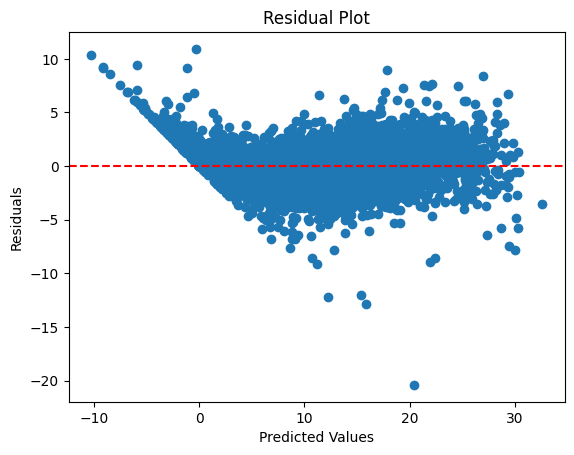

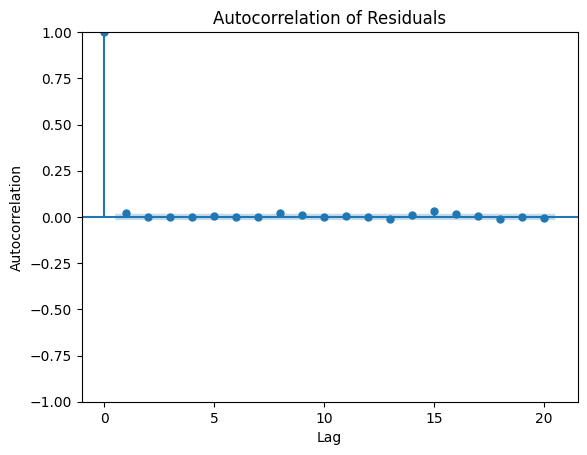

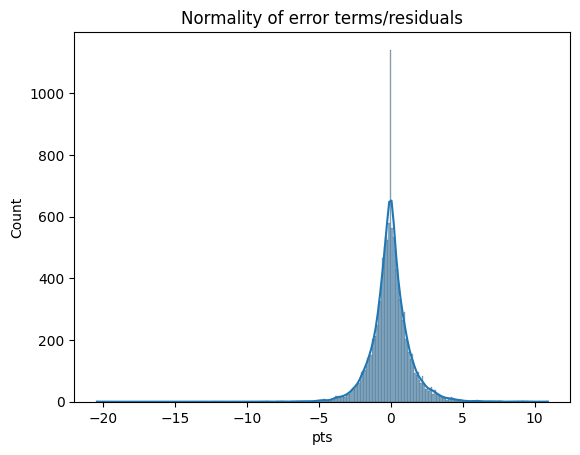

In [34]:
# Make predictions on the dataset
y_pred = ridge_final_pipeline.predict(X)

# Calculate residuals
residuals = y - y_pred

# Validate linear assumptions
assumptionValidation(y_pred, residuals)

### Model Interpretability

---


This section aims to interpret the linear model through two methods:

1. Analyzing **coefficients** to identify key non-scoring factors that significantly impact a player's seasonal performance.
2. Calculating **SHAP values** to understand what is the important predictors for individual predictions.

#### Analyzing Coefficients

In [35]:
# Extract final model from pipeline
ridge_model = ridge_final_pipeline.named_steps['ridge']

# Get the coefficients from the model
coefficients = ridge_model.coef_

# Assuming 'feature_names' matches the columns used in X_train
feature_names = X.columns

# Combine the feature names and their corresponding coefficients into a dictionary
feature_coefficients = dict(zip(feature_names, coefficients))

# Now, if you want to display them, for example, sorted by the absolute value of the coefficient:
sorted_feature_coefficients = sorted(feature_coefficients.items(), key=lambda item: abs(item[1]), reverse=True)

# Print out the feature names along with their coefficients
print("Feature coefficients from Ridge Regression:")
for feature, coeff in sorted_feature_coefficients[:8]:
    print(f"{feature}: {coeff}")

Feature coefficients from Ridge Regression:
reb: 3.1079144172468096
ast: 2.6948509357707513
usg_pct: 1.964154688535398
ast_pct: -0.993785525266237
dreb_pct: -0.9210067359761196
oreb_pct: -0.6429650266327452
ts_pct: 0.49102150644819237
gp: 0.28333912796628064


**Inferences:**

1. **Rebounds (reb)**: With the highest positive coefficient, this suggests a strong positive relationship with scoring averages. Players who tend to get more rebounds are likely to have a higher scoring average.

2. **Assists (ast)**: This has a significant positive coefficient as well, indicating that players who average more assists are also likely to score more points.

3. **Usage percentage (usg_pct)**: This has a positive coefficient, implying that players who are more involved in plays (usage rate) are predicted to have higher scoring averages.

4. **Assist percentage (ast_pct)**: The negative coefficient here is interesting—it might indicate that as players focus more on assisting, their personal scoring average might decrease, possibly because they are facilitating other players to score.

#### Calculating SHAP Values

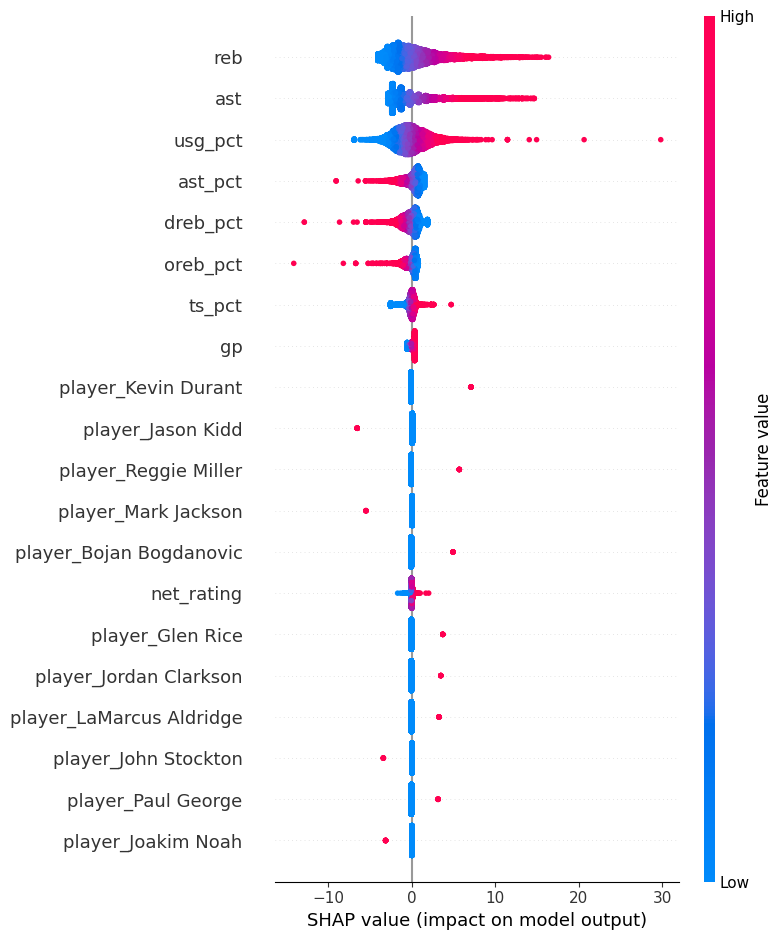

In [36]:
# Make sure your data is standardized as it was when fitting the model if it was done within a pipeline
# X is the training data used to fit the model, with column names
X_standardized = ridge_final_pipeline.named_steps['scaler'].transform(X)

# Initialize the SHAP explainer with the final model
explainer = shap.Explainer(ridge_model, X_standardized)

# Calculate SHAP values for the training set
shap_values = explainer(X_standardized)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_standardized, feature_names=X.columns)

- Plot suggests that 'reb' (rebounds), 'ast' (assists), and 'usg_pct' (usage percentage) are the top three non-scoring factors contributing to higher points scored by NBA players.

### Conclusion

---

**Impact of Rebounds**: There's a notable positive correlation between a player’s rebounding numbers and their scoring average. This indicates that players who excel at rebounding are often in positions to score more points.

**Role of Assists**: Assists are another predictor of scoring, suggesting that players who create scoring opportunities for others also tend to score well themselves, perhaps due to their involvement in offensive plays.

**Usage Rate**: A higher usage percentage is associated with higher scoring averages. Players with a higher usage rate are more integral to the offense and have more opportunities to score.

**Trade-Off with Assisting**: The inverse relationship with assist percentage could reflect a trade-off between facilitating others' scoring and scoring oneself, hinting at a player's dual role in scoring and playmaking.

### References

---



1. sklearn Documentation - https://scikit-learn.org/stable/index.html
2. Pandas Documentation - https://pandas.pydata.org/docs/index.html
3. SHAP Documentation - https://shap.readthedocs.io/en/latest/index.html
4. H2O Documentation - https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
5. ChatGPT - https://chat.openai.com/
6. NBA Website - https://www.nba.com/

### License

---

MIT License

Copyright (c) 2024 Pragnesh Anekal

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
